# Importing necessary packages and the data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
# imports the csv into the local notebook
df = pd.read_csv('real_estate_db.csv', encoding='latin-1')

# Cleaning the data

In [3]:
from scipy import stats

# drops duplicate rows and a nan column
df.drop_duplicates(subset=None, inplace=True)
df.drop('BLOCKID', axis=1, inplace=True)

# turns null characters into nan and drops all columns including nan
df = df.replace(r'^\s*$', np.nan, regex=True)
df.dropna(axis=0, inplace=True)

# drops outliers
# outliers are values that are beyond three std dev of the mean
for i in ['hs_degree','debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']:
  df = df[np.abs(stats.zscore(df[i])) < 3]

# samples 0.01 of the data
df_sampled = df.sample(frac=0.01)
df_sampled.head()

,UID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,primary,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
23157,264290,140,29,34,New Jersey,NJ,Jackson,Lakewood,City,tract,...,40.32147,38.00000,24.32967,566.14195,2269.0,0.58946,0.56038,0.09424,0.04402,0.05418
37392,291296,140,33,53,Washington,WA,Shoreline,Lake Forest Park City,Town,tract,...,41.36086,42.41667,22.37396,523.14078,2346.0,0.52814,0.43658,0.03386,0.01769,0.10611
35130,286981,140,375,48,Texas,TX,Amarillo,Amarillo City,Town,tract,...,34.64679,31.25000,22.23591,652.33396,2738.0,0.43283,0.38478,0.06800,0.04047,0.22612
1162,222506,140,13,4,Arizona,AZ,Surprise,Sun City West,CDP,tract,...,37.67536,37.66667,23.97614,553.57625,2188.0,0.52677,0.53937,0.00557,0.00557,0.16167
15246,249273,140,71,22,Louisiana,LA,New Orleans,Arabi,City,tract,...,39.58062,39.50000,22.61758,61.08074,265.0,0.97194,0.38144,0.21134,0.00000,0.02062


# Heatmap

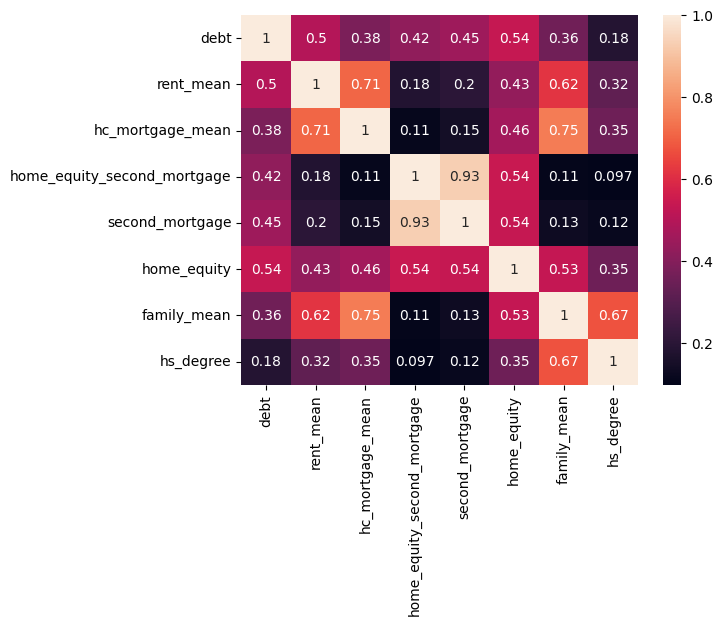

In [4]:
import seaborn as sb

data = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean', 'hs_degree']]
dataplot=sb.heatmap(data.corr(), annot=True)

# Function to create a boolean from graduation rate

In [5]:
# function to check whether or not the average person is graduated
def check_condition(value, threshold):
    if value > threshold:
        return 'Yes'
    else:
        return 'No'

# uses function to check whether values are greater or lesser than the mean and
# writes to new column
hs_degree_mean = df_sampled['hs_degree'].mean()
df_sampled['avg_person_graduated'] = df_sampled['hs_degree'].apply(lambda x: check_condition(x, hs_degree_mean))

# Neural Network

In [6]:
# defines X and y datasets
data_no_hs_degree = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']]
X = data_no_hs_degree
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

In [7]:
from sklearn.model_selection import train_test_split

# splits data into X and y training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# defines network model
model = Sequential()
model.add(Input(shape=(len(X_train.columns),)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score

# optimizer
initial_learning_rate = 0.001  # learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# learning rate scheduler
def lr_scheduler(epoch):
    return initial_learning_rate * 0.95 ** epoch
lr_callback = LearningRateScheduler(lr_scheduler)

# trains model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size = 1, epochs = 100, callbacks=[lr_callback])

Epoch 1/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4977 - loss: 377.8216 - learning_rate: 0.0010
Epoch 2/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5725 - loss: 84.1704 - learning_rate: 9.5000e-04
Epoch 3/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6094 - loss: 62.9688 - learning_rate: 9.0250e-04
Epoch 4/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5877 - loss: 54.6986 - learning_rate: 8.5737e-04
Epoch 5/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5954 - loss: 27.6621 - learning_rate: 8.1451e-04
Epoch 6/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5692 - loss: 34.5462 - learning_rate: 7.7378e-04
Epoch 7/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5513 - loss: 46.2170 - learning_rate: 7.3509e-04
Epoch 8/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5613 - loss: 56.2283 - learning_rate: 6.9834e-04
Epoch 9/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6130 - l

In [10]:
# performs predictions
y_hat = model.predict(X_test)
y_hat = [0 if val < 0.5 else 1 for val in y_hat]

# prints final accuracy
print(accuracy_score(y_test, y_hat))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0.8857142857142857


# Decision Tree Classification

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# find X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

# separates data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creates the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# makes predictions
y_pred = clf.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.70
Confusion Matrix:
[[12  4]
 [17 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.75      0.53        16
           1       0.90      0.69      0.78        54

    accuracy                           0.70        70
   macro avg       0.66      0.72      0.66        70
weighted avg       0.79      0.70      0.72        70



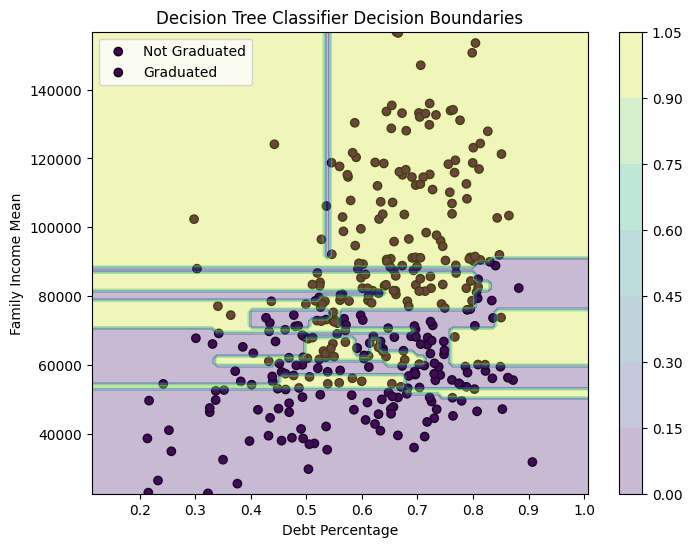

In [12]:
import matplotlib.pyplot as plt

# plots the decision tree
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0]['debt'], X[y == 0]['family_mean'], c=y[y == 0], cmap='viridis', edgecolors='k', label='Not Graduated')
plt.scatter(X[y == 1]['debt'], X[y == 1]['family_mean'], c=y[y == 1], cmap='viridis', edgecolors='k', label='Graduated')
xx, yy = np.meshgrid(np.linspace(X['debt'].min() - 0.1, X['debt'].max() + 0.1, 100), np.linspace(X['family_mean'].min() - 100, X['family_mean'].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = clf.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Decision Tree Classifier Decision Boundaries')
plt.colorbar()
plt.legend()
plt.show()

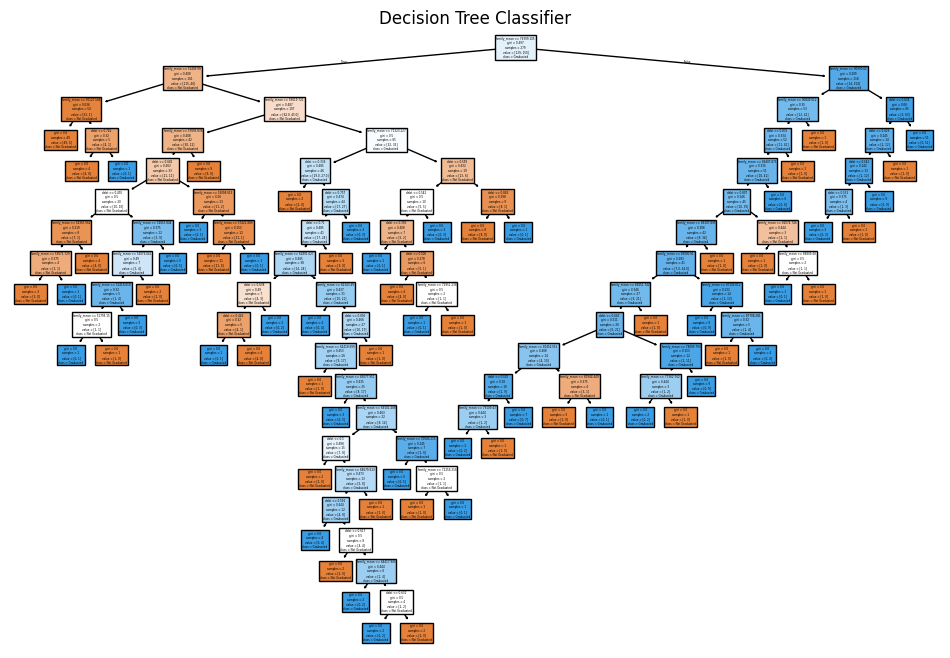

In [13]:
from sklearn.tree import plot_tree

# plots the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Graduated', 'Graduated'])
plt.title('Decision Tree Classifier')
plt.show()

# Random Forest Classification

In [14]:
from sklearn.ensemble import RandomForestClassifier

# identify the X and y
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['avg_person_graduated'].apply(lambda x: 1 if x=='Yes' else 0)

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creates the random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# makes predictions
y_pred = clf.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.71
Confusion Matrix:
[[10  6]
 [14 40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.62      0.50        16
           1       0.87      0.74      0.80        54

    accuracy                           0.71        70
   macro avg       0.64      0.68      0.65        70
weighted avg       0.77      0.71      0.73        70



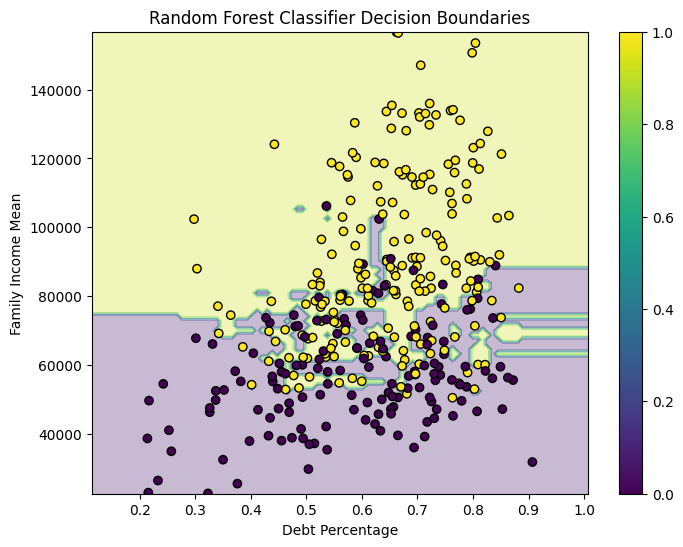

In [15]:
# plots boundaries
plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(X.values[:, 0].min() - 0.1, X.values[:, 0].max() + 0.1, 100), np.linspace(X.values[:, 1].min() - 100, X.values[:, 1].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = clf.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X.values[:, 0], X.values[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Random Forest Classifier Decision Boundaries')
plt.colorbar()
plt.show()

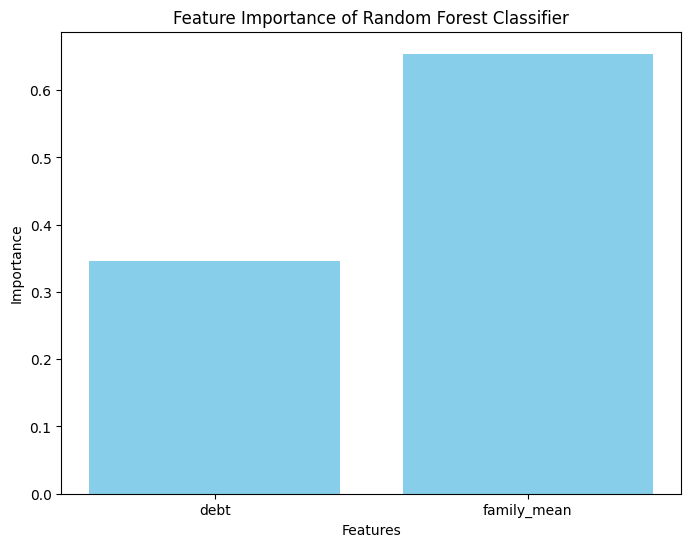

In [16]:
# plots features
plt.figure(figsize=(8, 6))
plt.bar(X.columns, clf.feature_importances_, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

# Interactive US Map

In [17]:
import plotly.express as px

avg_grad_rates = df.groupby('state_ab')['hs_degree'].mean().reset_index()
fig = px.choropleth(avg_grad_rates, locations='state_ab', locationmode='USA-states', color='hs_degree', hover_name='state_ab', color_continuous_scale='blues', title='Average High School Graduation Rates by State')
fig.update_layout(geo_scope='usa')
fig.show()

# Scatterplot of Degree Percentage versus Debt Percentage

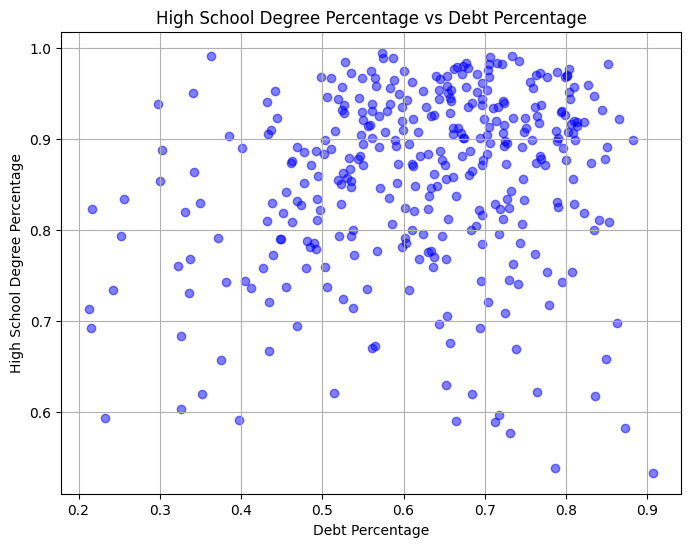

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['debt'], df_sampled['hs_degree'], color='b', alpha=0.5)
plt.title('High School Degree Percentage vs Debt Percentage')
plt.xlabel('Debt Percentage')
plt.ylabel('High School Degree Percentage')
plt.grid(True)
plt.show()

# Line Chart of Graduation Rate versus Debt Percentage

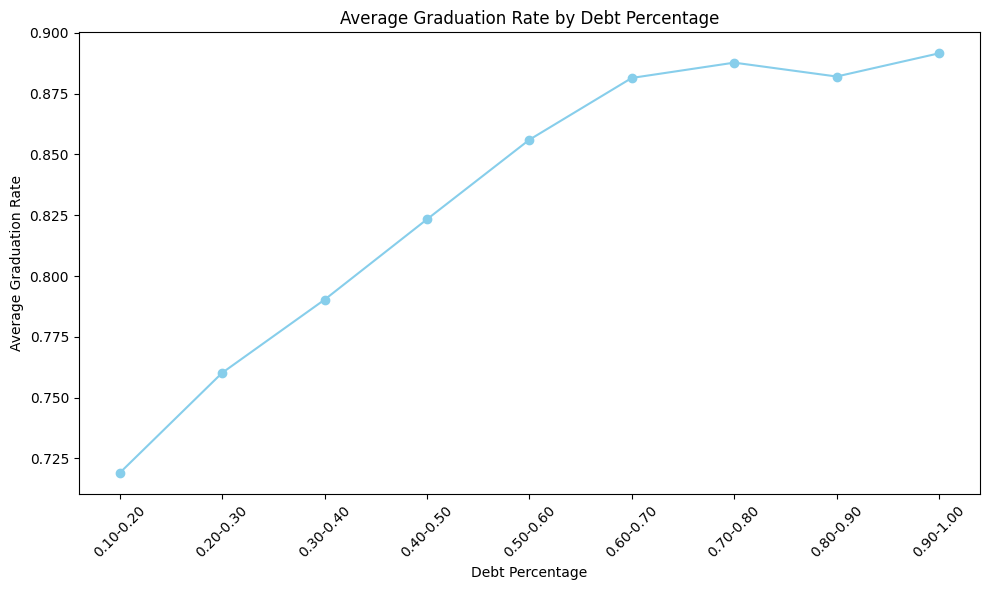

In [19]:
bins = np.linspace(0, 1, 11)
labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
df['debt_binned'] = pd.cut(df['debt'], bins=bins, labels=labels, right=False)
avg_graduation_rate = df.groupby('debt_binned', observed=True)['hs_degree'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_graduation_rate.index, avg_graduation_rate.values, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Debt Percentage')
plt.ylabel('Average Graduation Rate')
plt.title('Average Graduation Rate by Debt Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pair Plot of Rent Mean versus Graduation Rate

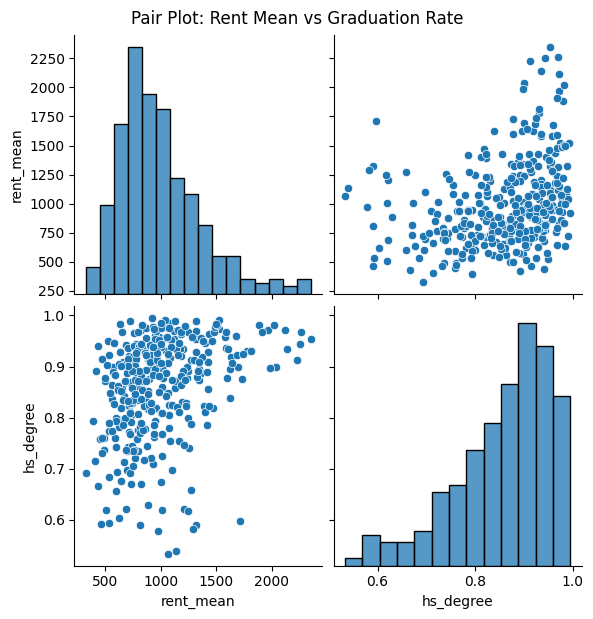

In [20]:
sb.pairplot(df_sampled[['rent_mean', 'hs_degree']], height=3)
plt.suptitle('Pair Plot: Rent Mean vs Graduation Rate', y=1.02)
plt.show()

# Joint Plot of Mortgage Mean versus Graduation Rate

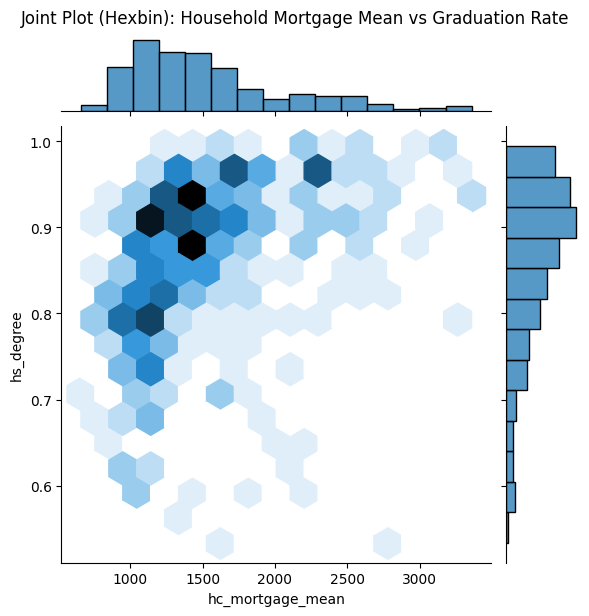

In [21]:
sb.jointplot(x='hc_mortgage_mean', y='hs_degree', data=df_sampled, kind='hex', height=6)
plt.suptitle('Joint Plot (Hexbin): Household Mortgage Mean vs Graduation Rate', y=1.02)
plt.show()

# Scatter Plot of Family Income Mean versus Graduation Rate

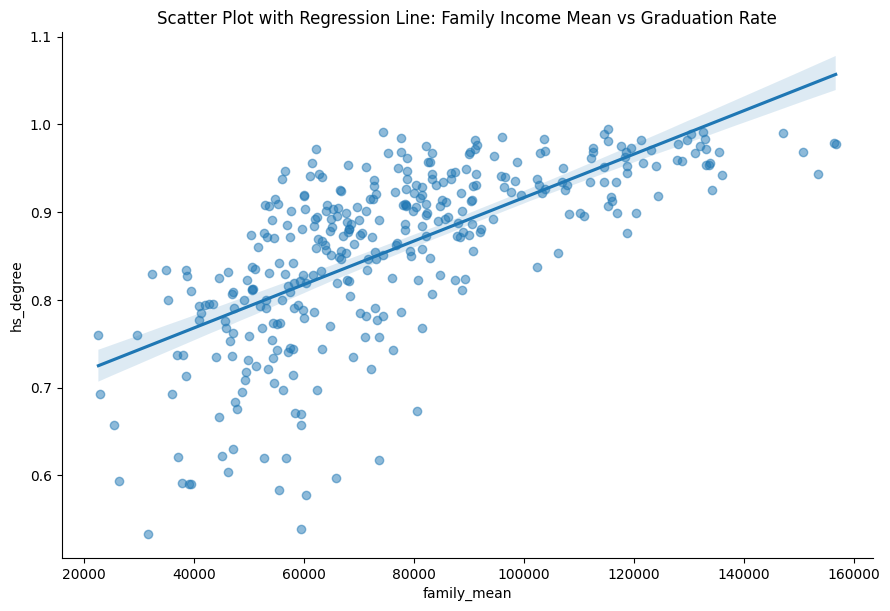

In [22]:
sb.lmplot(x='family_mean', y='hs_degree', data=df_sampled, height=6, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot with Regression Line: Family Income Mean vs Graduation Rate')
plt.show()